In [1]:
#https://github.com/interpretml/interpret
#pip install -U interpret

#Title: Reporting Ground Truth Divergence and why reporting MSE or AUC scores is not sufficient in probabilistic classification

#Experiment Description: To demonstrate new meaningful comparisons between logistic regression (scientific standard),
#and the Generalized Additive Pairwise Model also called Explainable Boosting Machine(GA2M/EBM).
#These experiments critically inspect the notion that GA2M/EBM is more interpretable than logistic regression. 
#It also reveals why reporting only the AUC score(derived from a notion of balancing true and false positive rate)
#in prediction is insufficient to consider one model to be better than the other. This experiment does that by
#showing which model performs better when focusing on the difference in outcome probability for each sample.
#I term this the "disagreement" between the models. The logistic regression seems to perform consistently better
#when identifying which of the models was closer to the ground truth
#when the "disagreement" is greater and greater.

#Contents:
#Graph 1: The probability prediction for each sample in the dataset on the X-Axis, and the frequency on the Y-Axis
#In terms of output probability the GA2M/EBM seem to be almost the same as logistic regression for
#this dataset at first glance. But this level of visibility does not associate each sample with its 
#corresponding value in the other model

#Graph 2: For each sample in the dataset, this graph shows the difference in probability prediction
#between the two models. In other words, the disagreement. Some of the samples disagree from 10-20%, and even 40%!
#Is one model performing much better in these extreme disagreements? Are disagreements equally likely? How often
#do these large disagreements occur?

#Graph 3/4: In the section that says "which model was closer to the ground truth".
##If you think about these two graphs together,
#the logistic regression seems to have consistently better performance than the GA2M/EBM model.
#Although GA2M/EBM is liked for its potentially more interpretable variable coefficient graphs,
#why accept vague interpretablity at the cost of bizzare performance mistakes?

#Next Steps: I'm going to apply this sequence to the other datasets that the authors used in the open source github.
#Also I can vary the number of interaction terms in the GA2M model and report the results jointly.


#Context: GA2M/EBM allows the coefficent for each variable to vary more freely than logistic regression.
#Ex: In logistic regression if the coefficent on Age is 3, then the contribution to the outcome prediction as you
#increase the input Age by 1 unit at a time is another 3 fixed probability units. In GA2M/EBM, 
#the model "learns" a continous 
#function that determines the contribution of that variable which could vary nonlinearly such as a parobola. 
#Furthermore, the model learns 2D interactions which can also be visualized, but as heatmaps. However, 
#when the model includes 2D interaction terms this confounds the interpretation of a single variable contribution
#to the outcome prediction. This is another reason why the notion that the authors are pushing that the algorithm
#is more interpretable than logistic regression can seem overblown. Is GA2M/EBM merely a fuzzy
#approximation of logistic regression without any standout benefits? Is it always sacrificing performance
#on a subset of the data for "interpetability" and that's why only AUC is being reported?


#GA2M/EBM is being pushed by Microsoft AI as a part of their InterpretML open source project.

#About this author: Previously Acknowledged in the Contributors Section of the open source InterpretML project

In [2]:
#Can Also test across time
#Dataset: Should be able to handle any

import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.mlab as mlab
%matplotlib inline
from interpret import show
from interpret.data import ClassHistogram
from interpret.glassbox import ExplainableBoostingClassifier, LogisticRegression, ClassificationTree, DecisionListClassifier
from interpret.perf import ROC
from interpret.glassbox import LogisticRegression, ClassificationTree
#without the class structure single shot each time
from interpret import show
from interpret.data import ClassHistogram
from interpret.glassbox import ExplainableBoostingClassifier, LogisticRegression, ClassificationTree, DecisionListClassifier
from interpret.perf import ROC
from interpret.glassbox import LogisticRegression, ClassificationTree
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

In [3]:
#Upload Data and Data Cleanup

df = pd.read_csv("/Users/gabrielalon/Desktop/heartdisease.csv")
df.columns = [
    "male","age","education","currentSmoker","cigsPerDay","BPMeds","prevalentStroke","prevalentHyp","diabetes","totChol","sysBP","diaBP","BMI","heartRate","glucose","TenYearCHD"
]
print("Nan missing values by column")
#Number of Nans by column
missing_val_count_by_column = (df.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])
print(len(df))

Nan missing values by column
education     105
cigsPerDay     29
BPMeds         53
totChol        50
BMI            19
heartRate       1
glucose       388
dtype: int64
4240


In [4]:
#Common practice to fill in the mean of the empty values for prediction algorithm to work
df.fillna(df.mean(), inplace=True)
missing_val_count_by_column = (df.isnull().sum())
print("No Missing values remaining if empty below")
print(missing_val_count_by_column[missing_val_count_by_column > 0])
print(len(df))

No Missing values remaining if empty below
Series([], dtype: int64)
4240


In [5]:
#Alternative to filling in the mean is to drop the NaN rows

#print(missing_val_count_by_column[missing_val_count_by_column > 0])
#df.dropna(axis=0,inplace=True)
#print("No Missing values remaining if empty below")
#missing_val_count_by_column = (df.isnull().sum())
#print(len(df))


In [6]:
def splitting(df):
    df = df
    train_cols = df.columns[0:-1]
    label = df.columns[-1]
    X = df[train_cols]
    y = df[label] 
    #y = df[label].apply(lambda x: 0 if x == " <=50K" else 1) #Turning response into 0 and 1
    seed = 1
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)
    return [X_train, y_train, X_test, y_test, X, y]
        

In [7]:
split_data = splitting(df)
X_train = split_data[0] 
y_train = split_data[1]
X_test = split_data[2] 
y_test = split_data[3]
X = split_data[4]
y = split_data[5]

In [8]:
ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)
ebm_global = ebm.explain_global()
#show(ebm_global)

In [10]:
hist = ClassHistogram().explain_data(X_train, y_train, name = 'Train Data')
#show(hist)
seed = 1
#To specificy specific interaction pairs
#ebm = ExplainableBoostingClassifier(random_state=seed)
#ebm = ExplainableBoostingClassifier(interactions=[[0, 1], [2, 3]])
#To just have a certain number of interaction pairs
ebm = ExplainableBoostingClassifier(interactions=6, random_state=seed)
ebm.fit(X_train, y_train)   #Works on dataframes and numpy arrays
ebm_global = ebm.explain_global(name='EBM')
# show(ebm_global)
print(ebm.intercept_, "The intercept in the model known as the baseline \n")
ebm_local = ebm.explain_local(X_test, y_test, name='EBM')
print(ebm_local.data(1)['perf'])
print('predicted',ebm_local.data(1)['perf']['predicted'])
#show(ebm_local)
ebm_perf = ROC(ebm.predict_proba).explain_perf(X_test, y_test, name='EBM')
#show(ebm_perf)
#ebm_perf is AUC performance

#Length of available data in ebm_local.data is only in the test set???

[-1.94679907] The intercept in the model known as the baseline 

{'actual': 0, 'predicted': 0.08644075660117712, 'residual': -0.08644075660117712}
predicted 0.08644075660117712


In [11]:
#iterate through all the actual and predicted values and compute the mean squared error on the test set
#for i in ebm_local_data(1)
#mean_squared_error(y_test, y)
print(y_test)

534     0
2751    0
3599    0
518     0
3813    0
       ..
1649    1
4172    0
2401    0
3475    0
1945    0
Name: TenYearCHD, Length: 848, dtype: int64


In [12]:
#find a way to actually refer directly to the iterable range
#print((ebm_local.data(84)))
list_predicted_ebm = []
ground_truth_ebm = []
ebm_len = len(y_test)
for i in range(ebm_len):
    list_predicted_ebm.append(ebm_local.data(i)['perf']['predicted'])
    ground_truth_ebm.append(ebm_local.data(i)['perf']['actual'])

In [13]:
#validating that the ground truth are the same
#print(list_predicted_ebm)
#print(ground_truth_ebm)
#print((y_test.iloc[0:-1]))

for i in range(len(y_test)):
    if (y_test.iloc[i]) == (ebm_local.data(i)['perf']['actual']):
        pass
    else:
        print("fail")

In [14]:
#Training the other models below
# We have to transform categorical variables to use Logistic Regression and Decision Tree
seed=1
X_enc = pd.get_dummies(X, prefix_sep='.')
feature_names = X_enc.columns

X_train_enc, X_test_enc, y_train, y_test = train_test_split(X_enc, y, test_size=0.20, random_state=seed)

#logistic regression
lr = LogisticRegression(random_state=seed, feature_names=feature_names, penalty='l2')
lr.fit(X_train_enc, y_train)
lr_perf = ROC(lr.predict_proba).explain_perf(X_test_enc, y_test, name='Logistic Regression')
#help(lr)
#Classification Tree
tree = ClassificationTree()
tree.fit(X_train_enc, y_train)
tree_perf = ROC(tree.predict_proba).explain_perf(X_test_enc, y_test, name='Classification Tree')
#show(tree_perf)
#show(ebm_perf)
#print(lr.__abstractmethods__)
#print(lr.__dict__)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [15]:
#Plotting two AUC graphs or getting the scores is not sufficient for understanding who was
#actually impacted (patients or samples). Note below the graphs look the same. Logistic performs "better" however.
show(lr_perf)

<!-- http://127.0.0.1:7887/4754136144/ -->

In [16]:
#Recall that a higher AUC "Area under the Curve" is considered better

In [17]:
show(ebm_perf)

<!-- http://127.0.0.1:7887/4429051384/ -->

In [18]:
#plot the overlapping top see if theres a perfomance region that overlaps

In [19]:
#probs = lr.predict_proba(X_enc)
probs = lr.predict_proba(X_test_enc)
print(probs[0][1])
list = []
for key in probs:
    list.append(key)
print(len(list), "next")
newlist = []
for i in (list):
    newlist.append((i[1]))
print(len(newlist))
print(len(list_predicted_ebm))
  #  print(list[i])
#The first index refers to the probability that the data belong to class 0,
#and the second refers to the probability that the data belong to class 1

#I'm going to use the second index since its convention to think in context of predicted the class 1
logistic_predicted =[]
for i in range(len(list)):
   logistic_predicted.append(list[i][1])

0.09916454919691066
848 next
848
848


In [20]:
#MSE and RMSE for logistic
mse = mean_squared_error(logistic_predicted, ground_truth_ebm)
from math import sqrt
print("for logistic")
print("MSE:",mse)
rmse = sqrt(mse)
print("RMSE:",rmse)

for logistic
MSE: 0.11727486508783502
RMSE: 0.3424541795449941


In [21]:
#For EBM/GA2M Computing Mean Squared Error and Root Mean Squared Error 
mse = mean_squared_error(list_predicted_ebm, ground_truth_ebm)
from math import sqrt
print("for EBM/GA2M")
print("MSE:",mse)
rmse = sqrt(mse)
print("RMSE:",rmse)

for EBM/GA2M
MSE: 0.11998381666854355
RMSE: 0.34638680209924794


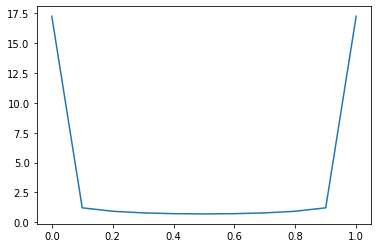

In [121]:
# plot impact of logloss with balanced datasets
from sklearn.metrics import log_loss
from matplotlib import pyplot
from numpy import array
# define a balanced dataset
testy = [0 for x in range(50)] + [1 for x in range(50)]
# loss for predicting different fixed probability values
predictions = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
losses = [log_loss(testy, [y for x in range(len(testy))]) for y in predictions]
# plot predictions vs loss
pyplot.plot(predictions, losses)
pyplot.show()

In [21]:
#off by one?
#diff = list_predicted_ebm-x
#print(len(list_predicted_ebm))
#print(len(x))

# Make sure that these are all graphs on the test set only?

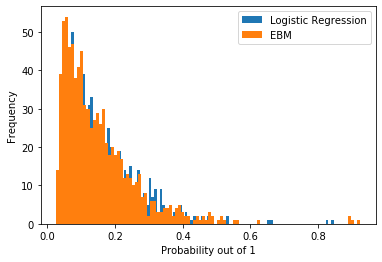

In [22]:
#x = newlist
x = logistic_predicted
fig, ax = plt.subplots()
ax.hist(x, 100, label='Logistic Regression')
ax.hist(list_predicted_ebm, 100, label='EBM')
#plt.hist(list_predicted_ebm, bins = 100, label='$y = numbers')
ax.set_ylabel('Frequency')
ax.set_xlabel('Probability out of 1')
ax.legend()

#Why is there so much more data for the logistic regression???!

#Note you can't see which sample person is the same across each model

Text(0.5, 0, 'Difference in Probability out of 1')

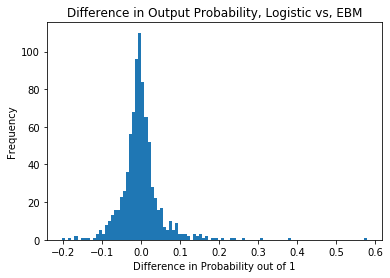

In [23]:
subtracted = [list_predicted_ebm-x for list_predicted_ebm, x in zip(list_predicted_ebm,x)]
fig, axs = plt.subplots()

axs.hist(subtracted, bins = 100)
axs.set_title('Difference in Output Probability, Logistic vs, EBM')
axs.set_ylabel('Frequency')
axs.set_xlabel('Difference in Probability out of 1')

# Calibration Plot



In [57]:
#x axis: output probability of each model
#y axis: proportion of those samples whole label was (1)
print(len(ground_truth_ebm))
print((ground_truth_ebm[847]))
if ground_truth_ebm[5] == 0:
    print("yes")
print(ground_truth_ebm[17])
print(ground_truth_ebm)

848
0
yes
1
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 

In [49]:
index = -1

In [119]:
#consider two dictionaries or dictionary of dictionaries? I need to check the score (done) as well as its ground truth

#the bin size percent where 10 is 10 percent
length = len(ground_truth_ebm)-1
bin_size = 10
bin_list = []
for i in range(0,11,1):
  bin_list.append(i)
print(bin_list)
d = {} 
for i in bin_list: 
    d[i] = []  
val = {} 
for i in bin_list: 
    val[i] = []  
print(val)
for i in bin_list:
    index = 0
    for y in list_predicted_ebm:
        if y<bin_list[i]/10 and y>bin_list[i-1]/10:
              #  print(y, i/10)
            val[(i)].append(y)
            d[(i)].append(ground_truth_ebm[index])
               # d[(i)].append(1)
           # print(ground_truth_ebm[index],"index name right", index)
            if index < length:
                index +=1
             #   print(index)
print(val[1])
print(d[1])        
            #i need to retrieve the sample indeces that are true for each output probability bin, for each model seperately,
#and add those to a dictionary with the key being the sample index name

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: []}
[0.08644075660117712, 0.06886131127466494, 0.060588508441414696, 0.04422764229313061, 0.07576447943370941, 0.07702207834494484, 0.08316658469886032, 0.05556386419993742, 0.07481316844702465, 0.053267189688142536, 0.07933161001759391, 0.0759749014965518, 0.09079423605241112, 0.04913452303515384, 0.08327402283152337, 0.04949504757052977, 0.08059801241768405, 0.0946172306530083, 0.06886507901000972, 0.0502927946491092, 0.08319666398291822, 0.06920202694421661, 0.06511709308745219, 0.08381599976059648, 0.03960346021368641, 0.08941753747506774, 0.0930668451550731, 0.03281494799970349, 0.08282732081698568, 0.031140752061673046, 0.06176457572767016, 0.04521726419332833, 0.031044663232693698, 0.03670633998151871, 0.05590865332029487, 0.09722925562812487, 0.05967068963257962, 0.08648536669920577, 0.05701948196339134, 0.05383259052132429, 0.04143589872727655, 0.09866958649626216, 0.0

In [116]:
new_dict = dict()
for k, v in d.items():
    print("{{{0}: {1}}}".format(k, sum(v)))
dict2 = {}
for key in d:
    dict2[key] = sum(d[key])
print(dict2)

{0: 0}
{1: 47}
{2: 43}
{3: 15}
{4: 3}
{5: 1}
{6: 0}
{7: 0}
{8: 0}
{9: 0}
{10: 0}
{0: 0, 1: 47, 2: 43, 3: 15, 4: 3, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0}


In [ ]:
"""Logistic Numbers for comparison
{0: 0}
{1: 48.722647679534234}
{2: 45.762445767160735}
{3: 19.958191131768285}
{4: 9.445850571644119}
{5: 2.064829878604269}
{6: 0.1935699882265126}
{7: 0.1935699882265126}
{8: 0}
{9: 0.1935699882265126}
"""

In [117]:
{k:sum(1 for x in v if x != None) for k,v in d.items()}

{0: 0, 1: 340, 2: 303, 3: 132, 4: 43, 5: 19, 6: 6, 7: 1, 8: 0, 9: 3, 10: 1}

# Logistic Calibration Plot

In [123]:
#x axis: output probability of each model
#y axis: proportion of those samples whole label was (1)
#print(len(logistic_predicted))
#print((logistic_predicted[847]))
#if logistic_predicted[5] == 0:
#    print("yes")
#print(logistic_predicted[17])
#print(logistic_predicted)

In [124]:
#consider two dictionaries or dictionary of dictionaries? I need to check the score (done) as well as its ground truth

#the bin size percent where 10 is 10 percent
length = len(logistic_predicted)-1
bin_size = 10
bin_list = []
for i in range(0,11,1):
  bin_list.append(i)
print(bin_list)
d = {} 
for i in bin_list: 
    d[i] = []  
val = {} 
for i in bin_list: 
    val[i] = []  
print(val)
for i in bin_list:
    index = 0
    for y in logistic_predicted:
        if y<bin_list[i]/10 and y>bin_list[i-1]/10:
              #  print(y, i/10)
            val[(i)].append(y)
            d[(i)].append(logistic_predicted[index])
               # d[(i)].append(1)
           # print(ground_truth_ebm[index],"index name right", index)
            if index < length:
                index +=1
             #   print(index)
print(val[1])
print(d[1])        
            #i need to retrieve the sample indeces that are true for each output probability bin, for each model seperately,
#and add those to a dictionary with the key being the sample index name

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: []}
[0.09916454919691066, 0.09440543902960194, 0.04914288902011408, 0.05010262137208851, 0.0914218062853557, 0.042602612751663486, 0.07694083169848813, 0.08184954391476465, 0.06645468117583357, 0.07183149511017636, 0.0949394324337713, 0.08098068502570878, 0.056454158991302836, 0.06687784346620161, 0.060940538176038124, 0.06412561737201157, 0.07533502410334837, 0.07357346657969083, 0.05934441219395126, 0.09240137411860506, 0.0697460721277867, 0.0493568404106986, 0.06797851892005587, 0.07600539051255155, 0.0693345657019571, 0.09500556667949077, 0.040958139834909195, 0.0966786406583737, 0.038121644758658986, 0.0923190883307006, 0.044072680237940476, 0.0627708645237131, 0.03508772452044042, 0.05405169935716301, 0.0988996024729262, 0.0739943952294627, 0.05837392656556048, 0.06367273055494134, 0.05502327853874732, 0.07364368158393553, 0.05339983091070431, 0.07799489607929658, 0.07795

In [125]:
new_dict = dict()
for k, v in d.items():
    print("{{{0}: {1}}}".format(k, sum(v)))
dict2 = {}
for key in d:
    dict2[key] = sum(d[key])
print(dict2)

{0: 0}
{1: 48.722647679534234}
{2: 45.762445767160735}
{3: 19.958191131768285}
{4: 9.445850571644119}
{5: 2.064829878604269}
{6: 0.1935699882265126}
{7: 0.1935699882265126}
{8: 0}
{9: 0.1935699882265126}
{10: 0}
{0: 0, 1: 48.722647679534234, 2: 45.762445767160735, 3: 19.958191131768285, 4: 9.445850571644119, 5: 2.064829878604269, 6: 0.1935699882265126, 7: 0.1935699882265126, 8: 0, 9: 0.1935699882265126, 10: 0}


In [126]:
{k:sum(1 for x in v if x != None) for k,v in d.items()}

{0: 0, 1: 326, 2: 305, 3: 135, 4: 61, 5: 15, 6: 2, 7: 2, 8: 0, 9: 2, 10: 0}

In [118]:
#in each key of dictionary find the ratio of 1/total samples in that key
#create a new dictionary with the same keys and the new associated values will be that ratio

In [26]:
#Checking to see if the examples where EBM and Logistic Disagree the most 
#ie: by more than 10% probability, how often was each model closer to the truth in the dataset

In [27]:
#If you only want to see the disagreement greater than one particular value
#and the corresponding samples set the parameter here and run the method model_disagreement below.
disagreement = 0.05

In [28]:
def model_disagreement(disagreement):
    ebm_wins = 0
    logistic_wins = 0
    y_test_index = y_test.tolist()
    for i in range(len(subtracted)):
        if subtracted[i] > disagreement:
        #    print("patient #", i, "disagreement of", 
            round(subtracted[i]*100,2),'%', 'EBM:', round(list_predicted_ebm[i]*100,2), 
            'logistic', round((x[i]*100),2), 'ground truth', y_test_index[i]
            if abs(list_predicted_ebm[i]-y_test_index[i]) < abs(x[i]-y_test_index[i]):
              #  print('EBM was closer above')
                ebm_wins +=1
            else:
                logistic_wins +=1
    return(logistic_wins/(ebm_wins+logistic_wins))
def model_disagreement_sample_size(disagreement):
    ebm_wins = 0
    logistic_wins = 0
    y_test_index = y_test.tolist()
    for i in range(len(subtracted)):
        if subtracted[i] > disagreement:
        #    print("patient #", i, "disagreement of", 
            round(subtracted[i]*100,2),'%', 'EBM:', round(list_predicted_ebm[i]*100,2), 
            'logistic', round((x[i]*100),2), 'ground truth', y_test_index[i]
            if abs(list_predicted_ebm[i]-y_test_index[i]) < abs(x[i]-y_test_index[i]):
              #  print('EBM was closer above')
                ebm_wins +=1
            else:
                logistic_wins +=1
    return(ebm_wins+logistic_wins)
#print("Which model was closer to the ground truth in the extreme cases?")
#print("observe which number is bigger by how much")
#print(ebm_wins, 'ebm wins: when it was closer to the truth')
#print(logistic_wins, 'logistic wins: when it was closer to the truth')

# which model was closer to the ground truth?

In [29]:
#model_disagreement(disagreement)
#This print the per patient disagreement and ground truth for transparency
model_disagreement_data = []
model_disagreement_index = []
sample_size = []
for i in range(0,100,1):
    i = i/100
    if len(model_disagreement_index) == len(model_disagreement_data):
        try:
        #    print(i, model_disagreement(i))
            model_disagreement_data.append(model_disagreement(i))
            model_disagreement_index.append(i)
            sample_size.append(model_disagreement_sample_size(i))
        except:
            pass
print(sample_size)

[348, 244, 170, 125, 97, 74, 60, 55, 43, 36, 28, 25, 22, 20, 17, 14, 11, 9, 9, 7, 7, 6, 6, 5, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


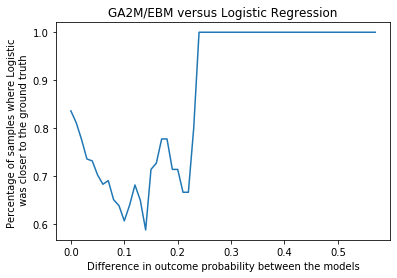

In [30]:
plt.plot(model_disagreement_index, model_disagreement_data) 
plt.xlabel('Difference in outcome probability between the models') 
plt.ylabel('Percentage of samples where Logistic \n was closer to the ground truth') 
plt.title('GA2M/EBM versus Logistic Regression') 
#plt.plot(model_disagreement_index, sample_size)
plt.show() 

Text(0.5, 1.0, 'GA2M/EBM versus Logistic Regression')

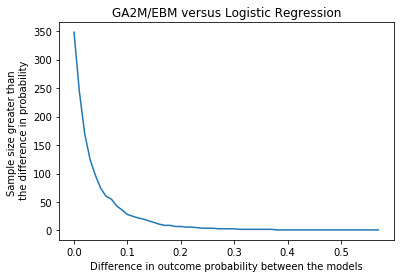

In [31]:
#If you think about this graph and the previous graph together, 
#the logistic regression seems to have consistently better performance than the GA2M/EBM model
#but only slightly better performane when the two models disagree by 12-17%, which happens to be
#when the number of samples greatly diminishes. But,as the threshold of disagreement increases logistic
#has even greater performance! The casualy of GA2M/EBM are some extremely poorly predicted members of the sample
#population.
plt.plot(model_disagreement_index, sample_size)
plt.xlabel('Difference in outcome probability between the models') 
plt.ylabel('Sample size greater than \n the difference in probability') 
plt.title('GA2M/EBM versus Logistic Regression') 

# The rest below is a work in progress

In [32]:
#For demonstration purposes this is the "interpretability" that the open source for GA2M/EBM
#gives. The first graph are the Ga2M/EBM coefficents for a particular sample and the second graph
#are the logistic coefficents for the same sample.

In [33]:
#The format z-1:z shows you datapoint z
ebm_local = ebm.explain_local(X_test[13:14], y_test[13:14], name='EBM')
show(ebm_local)

<!-- http://127.0.0.1:7523/4805311904/ -->

In [34]:
#The format z-1:z shows you datapoint z
#Observing the Per Explanatory Variable graphs for each of those key patients 
lr_local =lr.explain_local(X_test[13:14], y_test[13:14], name='lr')
show(lr_local)

<!-- http://127.0.0.1:7523/4525990632/ -->

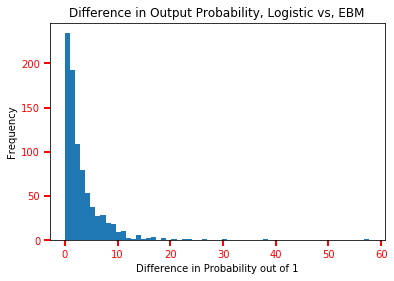

In [35]:
#plotting the absolute value
subtracted_absolute = [abs(100*(list_predicted_ebm-x)) for list_predicted_ebm, x in zip(list_predicted_ebm,x)]
fig, axn = plt.subplots()
axn.hist(subtracted_absolute, bins = 60)
axn.set_title('Difference in Output Probability, Logistic vs, EBM')
axn.set_ylabel('Frequency')
axn.set_xlabel('Difference in Probability out of 1')
#set_size(10,1)
axn.tick_params(direction='out', length=6, width=2, colors='r',
               grid_color='r', grid_alpha=2)

# These are the patients/samples with the greatest percentage difference in prediction

Text(0.5, 0, 'Difference in Probability out of 1')

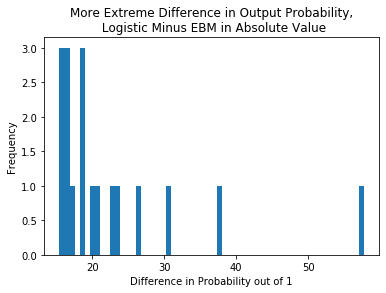

In [36]:
#plotting the absolute value
subtracted_absolute = [abs(100*(list_predicted_ebm-x)) if abs(100*(list_predicted_ebm-x))>10 else 0 for list_predicted_ebm, x in zip(list_predicted_ebm,x)]
#delete all the ones the filter passed over
#subtracted_absolute_greater_than = [subtracted_absolute
subtracted_absolute = [i for i in subtracted_absolute if i>15] 
fig, axn = plt.subplots()
axn.hist(subtracted_absolute, bins = 60)
axn.set_title('More Extreme Difference in Output Probability,\n Logistic Minus EBM in Absolute Value')
axn.set_ylabel('Frequency')
axn.set_xlabel('Difference in Probability out of 1')
#set_size(10,1)

# The rest does not apply to this experiment

In [37]:
#Converting the logits to Probability. Seems like they were already in probability........
#add index to the lists before 
#subtracteding and sort by biggest difference to identify which sample had the most disagreement

#did that first subtraction even make sense given that there is a nonlinear conversion to the probability?!!!
#you should convert to probablity before subtracting

#https://sebastiansauer.github.io/convert_logit2prob/

#have to round off floats to do the conversion
logit = -2
def to_probability(logit):
    try:
        for i in range(len(logit)):
            odds = math.exp(logit[i])
            prob = odds/ (1 + odds)
            logit[i] = prob
        return(logit)
    except:
        print("no")
print(type(newlist))
print(type(list_predicted_ebm))

<class 'list'>
<class 'list'>


In [38]:
#Model ensemble better?